In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, StandardScaler # encode
# SVM
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from libsvm.svmutil import *
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from svm import SVM
import cupy as xp 


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ImportError: cannot import name 'SVM' from 'svm' (C:\Users\zhanq\AppData\Roaming\Python\Python39\site-packages\svm\__init__.py)

In [7]:
'''

df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv')
print(df.head())
print(df.columns)
print(df.shape)

'''

"\n\ndf = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv')\nprint(df.head())\nprint(df.columns)\nprint(df.shape)\n\n"

Useful Notebook: https://www.kaggle.com/code/chiaenchen/eda-predict-student-performance-from-game-play#Conclusion




1. Drop the feature which 'null' ratio > 50%
2. Encode string value, event_name and name
3. Fill missing item in coordinates by Forward fill
4. Remove features that are not relevant to predicting game performance, hover_duration, fullscreen, hq,music

In [8]:
dtypes = {"session_id": 'int64',
          "index": np.int16,
          "elapsed_time": np.int32,
          "event_name": 'category',
          "name": 'category',
          "level": np.int8,
          "page": np.float16,
          "room_coor_x": np.float16,
          "room_coor_y": np.float16,
          "screen_coor_x": np.float16,
          "screen_coor_y": np.float16,
          "hover_duration": np.float16,
          "text": 'category',
          "fqid": 'category',
          "room_fqid": 'category',
          "text_fqid": 'category',
          "fullscreen": np.int8,
          "hq": np.int8,
          "music": np.int8,
          "level_group": 'category'
         }

- 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
   'hover_duration', 'text_fqid', 'fullscreen', 'hq',
   'music', 'level_group'

In [9]:
#avoid memory error, use chunk
def process(chunk,data):
    # process data here
    #print(chunk.shape)
    
    # Remove the 'page','text_fqid,'fqid','text' column
    chunk.drop('page', axis=1, inplace=True)
    #chunk.drop('level', axis=1, inplace=True)
    #chunk.drop('fqid', axis=1, inplace=True)
    #chunk.drop('text', axis=1, inplace=True)
    
    
    # Remove Unrelate value
    chunk.drop('hover_duration', axis=1, inplace=True)
    chunk.drop('fullscreen', axis=1, inplace=True)
    chunk.drop('hq', axis=1, inplace=True)
    chunk.drop('music', axis=1, inplace=True)

    chunk.drop('room_coor_x', axis=1, inplace=True)
    chunk.drop('room_coor_y', axis=1, inplace=True)
    chunk.drop('screen_coor_x', axis=1, inplace=True)
    chunk.drop('screen_coor_y', axis=1, inplace=True)
    
    '''
    # Encode the 'even_name',  variable
    encoder = LabelEncoder()
    chunk['event_name'] = encoder.fit_transform(chunk['event_name'])
    chunk['name'] = encoder.fit_transform(chunk['name'])
    chunk['room_fqid'] = encoder.fit_transform(chunk['room_fqid'])
    '''
    
    # fill missing item by previous value, 
    # chunk[['room_coor_x', 'room_coor_y']].fillna(method='ffill', inplace=True)
    # chunk[['screen_coor_x', 'screen_coor_y']].fillna(method='ffill', inplace=True)
    
    # scale the data
    ...

    # Add the preprocessed chunk to the list
    data.append(chunk)

In [10]:
# load in data

#avoid memory error
chunk_size = 10000
data = []
data_generator = pd.read_csv('train.csv', chunksize=chunk_size, dtype=dtypes, nrows=1000000)
for chunk in data_generator:
    process(chunk,data)
# Concatenate all preprocessed chunks into a single DataFrame
data = pd.concat(data, axis=0)

# Load target label
target = pd.read_csv('train_labels.csv')



In [11]:
data.head(3)

,session_id,index,elapsed_time,event_name,name,level,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


The session_id of target contains the number of topics (q1-q8), which cannot be matched with the session_id of data. Because, add a new user_id which in target.(this idea refer to chiaenchen)
Use regular expressions to achieve this.

In [12]:
import re #regular expression

# split session_id by "-". -> 20090312431273200_q1: 20090312431273200 and 1
target["session_id"],target["q_id"] = target.session_id.str.split("_", expand = True)[0],target.session_id.str.split("_", expand = True)[1] # session_id is 20090312431273200
target["q_id"] = target["q_id"].apply(lambda x : re.sub("\D", "",x)) # remove all non-digit characters from the "question" column 

# to numeric
target["q_id"] = pd.to_numeric(target["q_id"])
target["session_id"] = pd.to_numeric(target["session_id"])
target.head(3)


,session_id,correct,q_id
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1


In [13]:
just_dummies = pd.get_dummies(data['event_name'])
data = pd.concat([data, just_dummies], axis=1)
data.head()

,session_id,index,elapsed_time,event_name,name,level,text,fqid,room_fqid,text_fqid,...,cutscene_click,map_click,map_hover,navigate_click,notebook_click,notification_click,object_click,object_hover,observation_click,person_click
0,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,...,1,0,0,0,0,0,0,0,0,0
1,20090312431273200,1,1323,person_click,basic,0,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,...,0,0,0,0,0,0,0,0,0,1
2,20090312431273200,2,831,person_click,basic,0,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,...,0,0,0,0,0,0,0,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,...,0,0,0,0,0,0,0,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,...,0,0,0,0,0,0,0,0,0,1


list of question; 
number of user in data; 
number of user in target; 




In [14]:
data['event_name'].value_counts()

navigate_click        428366
person_click          228050
cutscene_click        101077
object_click           82429
object_hover           43850
map_hover              40220
notification_click     24307
notebook_click         20577
map_click              20014
observation_click       8437
checkpoint              2673
Name: event_name, dtype: int64

In [15]:
target.to_csv("extended_target.csv", index=False)

Data analysis

In [16]:
# data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   session_id          1000000 non-null  int64   
 1   index               1000000 non-null  int16   
 2   elapsed_time        1000000 non-null  int32   
 3   event_name          1000000 non-null  category
 4   name                1000000 non-null  object  
 5   level               1000000 non-null  int8    
 6   text                361869 non-null   object  
 7   fqid                688448 non-null   object  
 8   room_fqid           1000000 non-null  category
 9   text_fqid           361871 non-null   object  
 10  level_group         1000000 non-null  category
 11  checkpoint          1000000 non-null  uint8   
 12  cutscene_click      1000000 non-null  uint8   
 13  map_click           1000000 non-null  uint8   
 14  map_hover           1000000 non-null  uint8   
 15 

Process data

In [17]:
count_var = ['event_name', 'fqid','room_fqid', 'text']
mean_var = ['elapsed_time','level']
event_var = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
            'map_click','observation_click','checkpoint','elapsed_time']

In [18]:
def click_convert(train):
    dfs = []
    for c in count_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in mean_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in event_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    #df = df.set_index('session_id')
    return df

In [19]:
import gc
df_merge = pd.merge(data, target, on= 'session_id')
gc.collect()

19

In [20]:
df_click_convert = click_convert(df_merge)
#df_final = pd.merge(df_click_convert, df_final, on= 'session_id')
# df_final.head(40)
gc.collect()

0

In [21]:
def convert_time(df_sessions):
    df_final = pd.DataFrame()
    df_final['session_id'] = df_sessions['session_id'].unique()
    df_final['year'] = df_final['session_id'].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    df_final['month'] = df_final['session_id'].apply(lambda x: int(str(x)[2:4]) + 1).astype(np.uint8)
    df_final['weekday'] = df_final['session_id'].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    df_final['hour'] = df_final['session_id'].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    df_final['minute'] = df_final['session_id'].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    df_final['second'] = df_final['session_id'].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    df_final['ms'] = df_final['session_id'].apply(lambda x: int(str(x)[12:15])).astype(np.uint16)
    df_final['noise'] = df_final['session_id'].apply(lambda x: int(str(x)[15:17])).astype(np.uint8)
    return df_final

In [22]:
df_final = convert_time(df_click_convert)
df_final = df_final.set_index(['session_id'])
df_final.index.get_level_values('session_id')
# day_map = {0: 'monday', 1: 'tuesday', 2:'wednesday', 3:'thursday', 4:'friday', 5:'saturday', 6:'sunday'}
df_final = pd.merge(df_click_convert, df_final, on= 'session_id')
# df_final.weekday = df_final.weekday.map(day_map)
df_final.head()

,session_id,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time,level,navigate_click_sum,person_click_sum,...,checkpoint_sum,elapsed_time_sum,year,month,weekday,hour,minute,second,ms,noise
0,20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,1458,396,...,18,254806866,20,10,3,12,43,12,732,0
1,20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,3060,2214,...,18,7866941796,20,10,3,12,43,12,732,0
2,20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,1854,1872,...,18,1903189248,20,10,3,12,43,12,732,0
3,20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,882,324,...,18,244278810,20,10,3,12,43,32,510,36
4,20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,11466,2610,...,18,58338203994,20,10,3,12,43,32,510,36


In [23]:
df_merge.head()

,session_id,index,elapsed_time,event_name,name,level,text,fqid,room_fqid,text_fqid,...,map_hover,navigate_click,notebook_click,notification_click,object_click,object_hover,observation_click,person_click,correct,q_id
0,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,...,0,0,0,0,0,0,0,0,1,1
1,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,...,0,0,0,0,0,0,0,0,1,2
2,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,...,0,0,0,0,0,0,0,0,1,3
3,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,...,0,0,0,0,0,0,0,0,1,4
4,20090312431273200,0,0,cutscene_click,basic,0,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,...,0,0,0,0,0,0,0,0,1,5


### reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

In [24]:
df_final.session_id.nunique()

886

In [25]:
df_final.index.nunique()

2658

In [26]:
# group by session_id
grouped_data = df_final.groupby('session_id')
grouped_data.head()

,session_id,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time,level,navigate_click_sum,person_click_sum,...,checkpoint_sum,elapsed_time_sum,year,month,weekday,hour,minute,second,ms,noise
0,20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,1458,396,...,18,254806866,20,10,3,12,43,12,732,0
1,20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,3060,2214,...,18,7866941796,20,10,3,12,43,12,732,0
2,20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,1854,1872,...,18,1903189248,20,10,3,12,43,12,732,0
3,20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,882,324,...,18,244278810,20,10,3,12,43,32,510,36
4,20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,11466,2610,...,18,58338203994,20,10,3,12,43,32,510,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,20100412005177230,13-22,10,51,13,204,1.152992e+06,16.943005,5184,2376,...,18,12016481364,20,11,4,12,0,51,772,30
2654,20100412005177230,5-12,10,44,11,141,4.133706e+05,8.445141,1404,2160,...,18,2373573816,20,11,4,12,0,51,772,30
2655,20100412013046310,0-4,7,11,3,18,3.609503e+04,0.230769,252,180,...,0,25338708,20,11,4,12,1,30,463,10
2656,20100412013046310,13-22,0,0,0,0,-1.000000e+00,-1.000000,0,0,...,0,0,20,11,4,12,1,30,463,10


In [27]:
df_final.head(50)

,session_id,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time,level,navigate_click_sum,person_click_sum,...,checkpoint_sum,elapsed_time_sum,year,month,weekday,hour,minute,second,ms,noise
0,20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,1458,396,...,18,254806866,20,10,3,12,43,12,732,0
1,20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,3060,2214,...,18,7866941796,20,10,3,12,43,12,732,0
2,20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,1854,1872,...,18,1903189248,20,10,3,12,43,12,732,0
3,20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,882,324,...,18,244278810,20,10,3,12,43,32,510,36
4,20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,11466,2610,...,18,58338203994,20,10,3,12,43,32,510,36
5,20090312433251036,5-12,11,45,11,120,5.549040e+05,8.840506,2070,1746,...,18,3945367710,20,10,3,12,43,32,510,36
6,20090312455206810,0-4,9,22,6,55,2.023980e+05,1.604027,1026,324,...,18,542831490,20,10,3,12,45,52,68,10
7,20090312455206810,13-22,11,47,12,160,9.586433e+05,17.706044,2214,1818,...,18,6281030718,20,10,3,12,45,52,68,10
8,20090312455206810,5-12,11,41,11,117,5.073953e+05,8.342857,1206,1728,...,18,2237613084,20,10,3,12,45,52,68,10
9,20090313091715820,0-4,11,24,6,56,6.208740e+04,1.789773,1440,396,...,18,196692876,20,10,3,13,9,17,158,20


In [28]:
df_final.columns

Index(['session_id', 'level_group', 'event_name_nunique', 'fqid_nunique',
       'room_fqid_nunique', 'text_nunique', 'elapsed_time', 'level',
       'navigate_click_sum', 'person_click_sum', 'cutscene_click_sum',
       'object_click_sum', 'map_hover_sum', 'notification_click_sum',
       'map_click_sum', 'observation_click_sum', 'checkpoint_sum',
       'elapsed_time_sum', 'year', 'month', 'weekday', 'hour', 'minute',
       'second', 'ms', 'noise'],
      dtype='object')

In [29]:
grouped_target = target.groupby('session_id')
target.head()

,session_id,correct,q_id
0,20090312431273200,1,1
1,20090312433251036,0,1
2,20090312455206810,1,1
3,20090313091715820,0,1
4,20090313571836404,1,1


In [30]:
target.q_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int64)

In [31]:
df_final = df_final.set_index('session_id')

In [32]:
FEATURES = [c for c in df_final.columns if c != 'level_group']

In [34]:
ALL_USERS = df_final.index.unique()
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df_final, groups=df_final.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df_final.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = target.loc[target.q_id==t].set_index('session_id').loc[train_users]
        
         # VALID DATA
        valid_x = df_final.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = target.loc[target.q_id==t].set_index('session_id').loc[valid_users]
        
        # TRAIN MODEl
        prob  = svm_problem(train_x[FEATURES].astype('float32'), train_y['correct'],isKernel=True)
        param = svm_parameter('-t 4 -c 4 -b 1')
        m = svm_train(prob, param)
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = m
        oof.loc[valid_users, t-1] = libsvm.svm_predict(m, valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 

TypeError: type of y: <class 'pandas.core.frame.DataFrame'> is not supported!

In [ ]:
"""
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Create an SVM classifier with a linear kernel
svm = SVC(kernel='linear')

# Train the model on the training set
svm.fit(X_train, y_train)

# Predict on the validation set and evaluate the performance
y_pred = svm.predict(X_val)
print(classification_report(y_val, y_pred))

# Predict on the test set and evaluate the performance
y_pred_test = svm.predict(X_test)
print(classification_report(y_test, y_pred_test))
"""

"\n# Split the data into train, validation, and test sets\nX_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)\nX_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)\n\n# Create an SVM classifier with a linear kernel\nsvm = SVC(kernel='linear')\n\n# Train the model on the training set\nsvm.fit(X_train, y_train)\n\n# Predict on the validation set and evaluate the performance\ny_pred = svm.predict(X_val)\nprint(classification_report(y_val, y_pred))\n\n# Predict on the test set and evaluate the performance\ny_pred_test = svm.predict(X_test)\nprint(classification_report(y_test, y_pred_test))\n"

In [ ]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = target.loc[target.q_id == k+1].set_index('session_id').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [ ]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

In [9]:
! pip install cuml-cu11 --extra_index_url=https://pypi.nvidia.com


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --extra_index_url


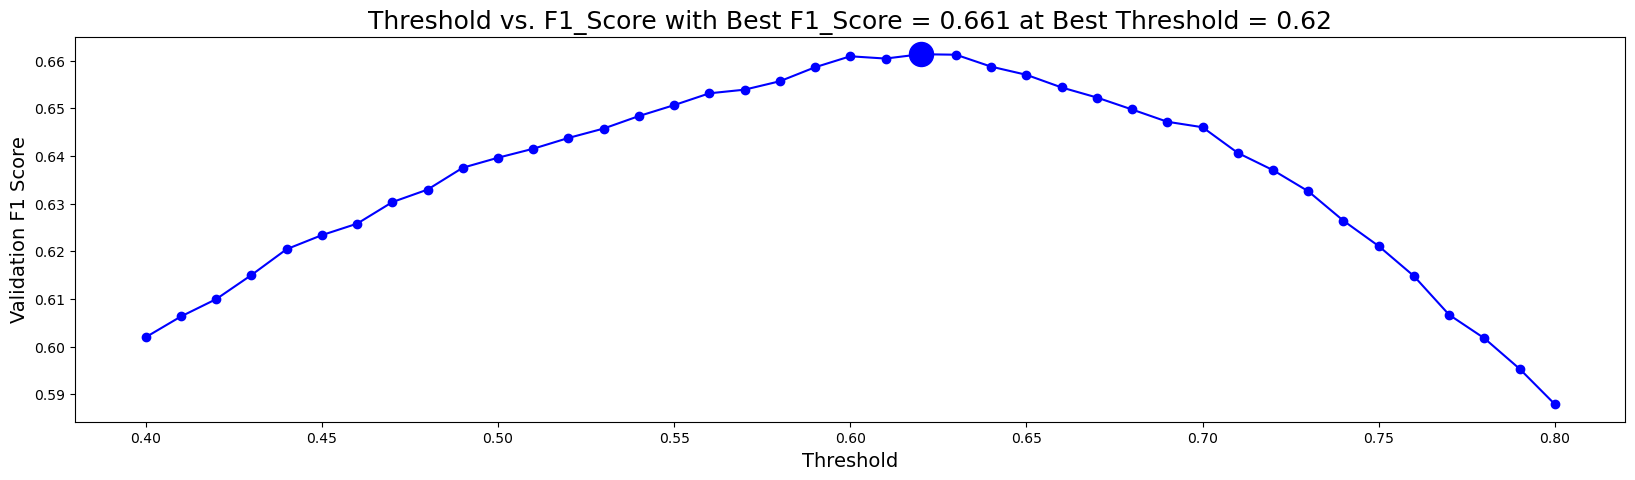

In [ ]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()